<a href="https://colab.research.google.com/github/hyewonleess/KU_stat_projects/blob/main/%EA%B3%A0%EA%B8%89%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly
from tqdm import tqdm

import statsmodels.api as sm
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, learning_curve, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import export_graphviz
from imblearn.under_sampling import *
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder
from scipy.stats import skew
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,classification_report, precision_recall_curve

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
data = pd.read_csv('/content/drive/My Drive/Kaggle/ml_project/bank-full.csv',header=0,sep=';')
print(data.shape)

(45211, 17)


## 1. Preview & understand data



In [59]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [60]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## 2. EDA & Feature Engineering
* `age`: category 로 만들기

*   `day`, `month`: 합치기 --> 이후 마지막 contact일로부터 얼마나 지났는지 계산
*   `pdays`: -1 값 처리 어떻게 할지 고민







### (1) bank client data
`age`, `job`, `marital`, `education`, `default`, `balance`, `houseing`, `loan`

In [61]:
data['age'].describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

In [62]:
# age 정의 함수
def get_ages(data):
  if data<30:
    data = '30-'
  elif data<40:
    data = '30s'
  elif data<65:
    data = '40-65'
  else:
    data = '65+'
  return data

data['age'] = data['age'].apply(lambda x: get_ages(x))

In [63]:
# y 비율 plot 함수
def bar_stack_target_ver_1(df,x_var):
    group = df.groupby([x_var,'y'])['job'].count()
    group = group/group.groupby(level=0).sum()
    group = group.reset_index().rename(columns={'job':'ratio'})
    
    sns.set_style('whitegrid')

    colors = ['lightgrey','limegreen']
    sns.barplot(data = group,x = x_var, y = 'ratio', hue = 'y', palette = colors)
    
    plt.title(f'{x_var} - y distribution', fontsize = 15); 
    plt.xlabel(f'{x_var}', fontsize = 10); plt.ylabel('Ratio(%)', fontsize = 10)
    plt.legend(loc = 'best')
    plt.show()

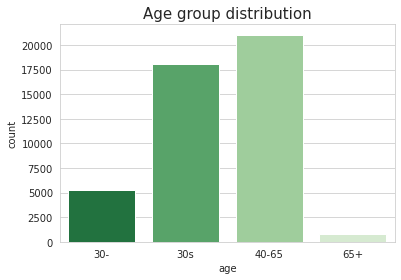

In [64]:
age_count = data['age'].value_counts().sort_index().reset_index().rename(columns={'index':'age','age':'count'})

sns.set_style('whitegrid')
sns.barplot(age_count['age'],age_count['count'],palette='Greens_r')
plt.title('Age group distribution',fontsize=15)
plt.show()

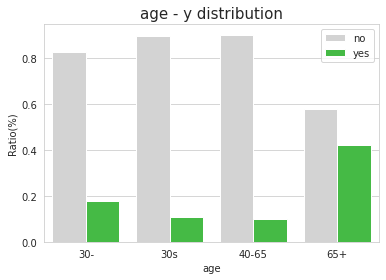

In [65]:
bar_stack_target_ver_1(data,'age')

### (2) Last contact of current campaign

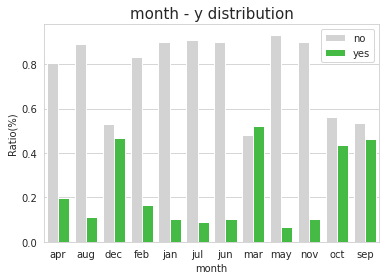

In [66]:
bar_stack_target_ver_1(data,'month')

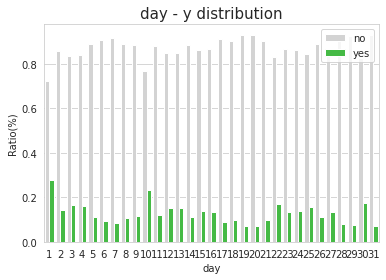

In [67]:
bar_stack_target_ver_1(data,'day')

In [68]:
data.drop(['day'],axis=1,inplace=True)

### (3) other attributes

In [69]:
# drop pdays ( too many missing values)
print(data[data['pdays']==-1].shape)
print(len(data[data['pdays']==-1])/len(data))

(36954, 16)
0.8173674548229414


In [70]:
data.drop(['pdays'],axis=1,inplace=True)

## Target
Target 변수는 0과 1의 비율이 매우 불균형하다.

In [71]:
data['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

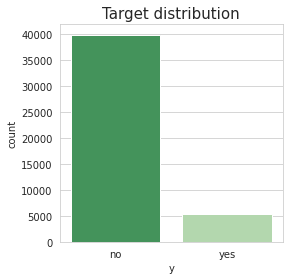

In [72]:
target_count = data['y'].value_counts().reset_index().rename(columns = {'index':'y','y':'count'})

def target_plot(data, x_var, y_var):
    plt.figure(figsize = (4,4))
    ax = plt.subplot(1,1,1)
    sns.set_style('whitegrid')
    sns.barplot(data=data,x = x_var,y = y_var ,palette = 'Greens_r', ax = ax)
    ax.set_title('Target distribution',fontsize=15); 
    plt.xlabel(x_var, fontsize=10); plt.ylabel(y_var, fontsize=10)
    plt.show()

target_plot(target_count, 'y', 'count')

In [73]:
# label encoding - target
encoder = LabelEncoder()
data['y'] = encoder.fit_transform(data['y'])
print(encoder.classes_)

['no' 'yes']


In [74]:
# MinMaxScaling
data[['balance','duration','previous']]=pd.DataFrame(MinMaxScaler().fit_transform(data[['balance','duration','previous']]),columns=['balance','duration','previous'])

In [75]:
data = pd.get_dummies(data)

## 3. Modeling
 + Random Forest(bagging)
 + Logistic Regression
 + LightGBM
 + SVM Classifier

In [76]:
# X, y
X = data.drop(['y'],axis=1)
y= data['y']

In [77]:
print(X.shape)
print(y.shape)

(45211, 52)
(45211,)


In [78]:
# nested cross validation 
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = KFold(n_splits=2, shuffle=True, random_state=0)

def nested_cross_val(model, X, y, params, outer_cv, inner_cv):
  train_accuracy = []
  outer_accuracy = []
  precisions = []
  recalls = []
  n_fold = 0
  for train_idx, test_idx in outer_cv.split(X,y): # outer loop
    X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]

    gs = GridSearchCV(model, param_grid = params, cv=inner_cv,scoring='accuracy') # inner loop - Hyperparameter tuning
    gs.fit(X_train,y_train)

    new_model = gs.best_estimator_
    train_pred = new_model.predict(X_train)
    pred = new_model.predict(X_test)

    t_accuracy = accuracy_score(train_pred,y_train)
    accuracy = accuracy_score(pred,y_test)
    precision = precision_score(pred,y_test)
    recall = recall_score(pred,y_test)

    train_accuracy.append(t_accuracy)
    outer_accuracy.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    n_fold +=1
    
    print(f'###### {n_fold}th fold result ######')
    print('Best parameter: ',gs.best_params_)
    print('Accuracy score: ', np.round(accuracy,4))

  final_accuracy = np.round(np.mean(outer_accuracy),4)
  return outer_accuracy, final_accuracy, train_accuracy, precisions, recalls


def nested_cross_val_over(model, X, y, params, outer_cv, inner_cv):
  train_accuracy = []
  outer_accuracy = []
  precisions = []
  recalls = []
  n_fold = 0
  for train_idx, test_idx in outer_cv.split(X,y): # outer loop
    X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_test = y[train_idx], y[test_idx]
    
    smote = SMOTE(random_state= 0)
    X_train_over, y_train_over = smote.fit_sample(X_train,y_train)

    gs = GridSearchCV(model, param_grid = params, cv=inner_cv,scoring='accuracy') # inner loop - Hyperparameter tuning
    gs.fit(X_train_over,y_train_over)

    new_model = gs.best_estimator_
    train_pred = new_model.predict(X_train_over)
    pred = new_model.predict(X_test)

    t_accuracy = accuracy_score(train_pred,y_train_over)
    accuracy = accuracy_score(pred,y_test)
    precision = precision_score(pred,y_test)
    recall = recall_score(pred,y_test)

    train_accuracy.append(t_accuracy)
    outer_accuracy.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    n_fold +=1
    
    print(f'###### {n_fold}th fold result ######')
    print('Best parameter: ',gs.best_params_)
    print('Accuracy score: ', np.round(accuracy,4))

  final_accuracy = np.round(np.mean(outer_accuracy),4)
  return outer_accuracy, final_accuracy, train_accuracy, precisions, recalls

### (1) Random Forest


In [79]:
rf = RandomForestClassifier(random_state=0)
rf_params = {'n_estimators':[100,150,200],'max_depth':[12,15,20]}

In [80]:
outer_accuracy_rf, final_accuracy_rf, train_accuracy_rf, precision_rf, recall_rf = nested_cross_val(rf, X, y, rf_params, outer_cv, inner_cv)

###### 1th fold result ######
Best parameter:  {'max_depth': 15, 'n_estimators': 200}
Accuracy score:  0.9069
###### 2th fold result ######
Best parameter:  {'max_depth': 15, 'n_estimators': 100}
Accuracy score:  0.9007
###### 3th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 100}
Accuracy score:  0.9049
###### 4th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 200}
Accuracy score:  0.9027
###### 5th fold result ######
Best parameter:  {'max_depth': 15, 'n_estimators': 200}
Accuracy score:  0.9013


In [81]:
outer_accuracy_rf2, final_accuracy_rf2, train_accuracy_rf2, precision_rf2, recall_rf2 = nested_cross_val_over(rf, X, y, rf_params, outer_cv, inner_cv)

###### 1th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 200}
Accuracy score:  0.8854
###### 2th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 200}
Accuracy score:  0.8833
###### 3th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 200}
Accuracy score:  0.8892
###### 4th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 200}
Accuracy score:  0.8816
###### 5th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 200}
Accuracy score:  0.8833


In [82]:
# 세부 모델 평가 결과 출력 함수
def get_result(model,X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=0)

  model.fit(X_train,y_train)
  pred = model.predict(X_test)
  print(classification_report(y_test,pred))
  print(confusion_matrix(y_test,pred))
  if model.__class__.__name__ != 'LogisticRegression':
    feat_imp = pd.DataFrame({'variable':X.columns, 'importance': model.feature_importances_}).sort_values(by='importance',ascending=False)
    # top 20
    feat_imp = feat_imp[:20]
    plt.figure(figsize=(8,10))
    sns.barplot(x = feat_imp['importance'],y= feat_imp['variable'],palette='Greens_r')
    plt.title('Feature importances',fontsize=15)
    plt.show()
  else:
    coefs = pd.Series(model.coef_.reshape(52,),index=X.columns)
    coefs = coefs.sort_values(ascending=False)
    coefs_top20 = coefs[:20]
    sns.barplot(x=coefs_top20.values, y=coefs_top20.index, palette='Greens_r') 
    plt.title('Regression Coefficients',fontsize=15)
    plt.show()

def get_result_over(model,X,y):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=0)
  
  X_train_over, y_train_over = SMOTE(random_state=0).fit_sample(X_train,y_train)
  model.fit(X_train_over,y_train_over)
  pred = model.predict(X_test)
  print(classification_report(y_test,pred))
  print(confusion_matrix(y_test,pred))
  if model.__class__.__name__ != 'LogisticRegression':
    feat_imp = pd.DataFrame({'variable':X.columns, 'importance': model.feature_importances_}).sort_values(by='importance',ascending=False)
    # top 20
    feat_imp = feat_imp[:20]
    plt.figure(figsize=(8,10))
    sns.barplot(x = feat_imp['importance'],y= feat_imp['variable'],palette='Greens_r')
    plt.title('Feature importances',fontsize=15)
    plt.show()
  else:
    coefs = pd.Series(model.coef_.reshape(52,),index=X.columns)
    coefs = coefs.sort_values(ascending=False)
    coefs_top20 = coefs[:20]
    sns.barplot(x=coefs_top20.values, y=coefs_top20.index, palette='Greens_r') 
    plt.title('Regression Coefficients',fontsize=15)
    plt.show()

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.39      0.48      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.68      0.71      9043
weighted avg       0.89      0.90      0.89      9043

[[7753  232]
 [ 648  410]]


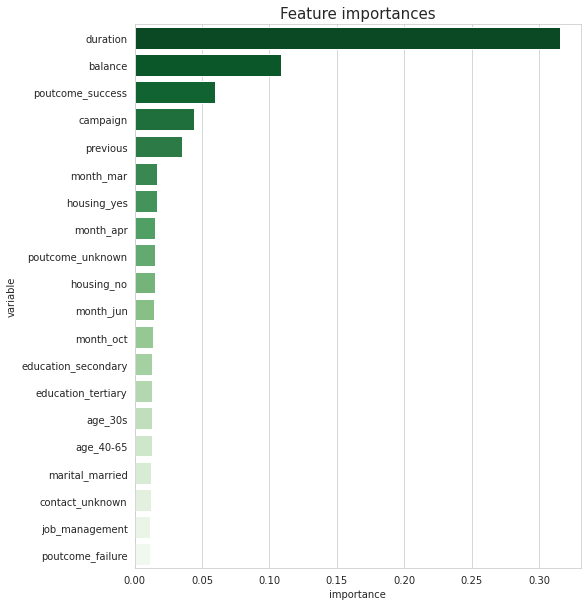

In [83]:
rf_tuned = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
get_result(rf_tuned,X,y)

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      7985
           1       0.51      0.69      0.59      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.80      0.76      9043
weighted avg       0.91      0.89      0.89      9043

[[7293  692]
 [ 328  730]]


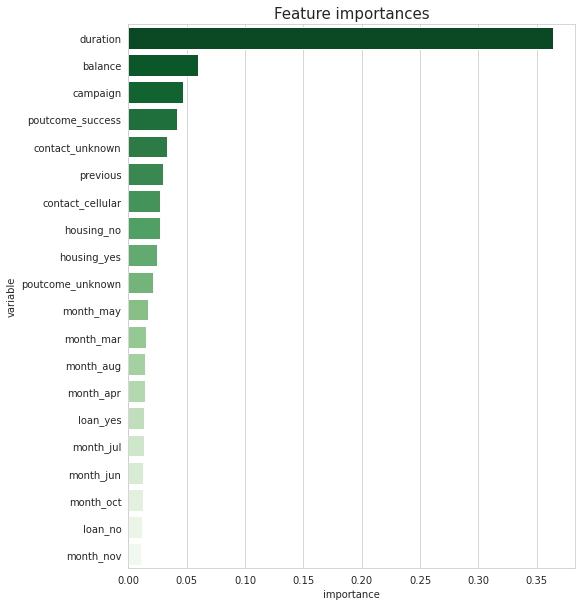

In [84]:
rf_tuned_over = RandomForestClassifier(n_estimators=200, max_depth=20, random_state=0)
get_result_over(rf_tuned_over,X,y)

### (2) LightGBM (boosting)

In [85]:
lgbm = LGBMClassifier(n_estimators=200,objective='binary',boost_from_average=False)

In [86]:
lgbm_params = {'n_estimators':[200,300,500],'max_depth':[10,15,20],'num_leaves':[20,30,50]}
outer_accuracy_lgbm, final_accuracy_lgbm, train_accuracy_lgbm, precision_lgbm, recall_lgbm = nested_cross_val(lgbm,X,y,lgbm_params,outer_cv,inner_cv)

###### 1th fold result ######
Best parameter:  {'max_depth': 10, 'n_estimators': 200, 'num_leaves': 20}
Accuracy score:  0.9085
###### 2th fold result ######
Best parameter:  {'max_depth': 15, 'n_estimators': 200, 'num_leaves': 20}
Accuracy score:  0.9061
###### 3th fold result ######
Best parameter:  {'max_depth': 15, 'n_estimators': 200, 'num_leaves': 20}
Accuracy score:  0.9084
###### 4th fold result ######
Best parameter:  {'max_depth': 10, 'n_estimators': 200, 'num_leaves': 20}
Accuracy score:  0.9051
###### 5th fold result ######
Best parameter:  {'max_depth': 10, 'n_estimators': 200, 'num_leaves': 20}
Accuracy score:  0.9023


In [87]:
outer_accuracy_lgbm2, final_accuracy_lgbm2, train_accuracy_lgbm2, precision_lgbm2, recall_lgbm2 = nested_cross_val_over(lgbm,X,y,lgbm_params,outer_cv,inner_cv)

###### 1th fold result ######
Best parameter:  {'max_depth': 10, 'n_estimators': 500, 'num_leaves': 50}
Accuracy score:  0.8985
###### 2th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 500, 'num_leaves': 30}
Accuracy score:  0.8963
###### 3th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 500, 'num_leaves': 50}
Accuracy score:  0.9002
###### 4th fold result ######
Best parameter:  {'max_depth': 20, 'n_estimators': 300, 'num_leaves': 50}
Accuracy score:  0.9005
###### 5th fold result ######
Best parameter:  {'max_depth': 10, 'n_estimators': 500, 'num_leaves': 50}
Accuracy score:  0.8955


              precision    recall  f1-score   support

           0       0.93      0.96      0.94      7985
           1       0.60      0.46      0.52      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.71      0.73      9043
weighted avg       0.89      0.90      0.90      9043

[[7665  320]
 [ 574  484]]


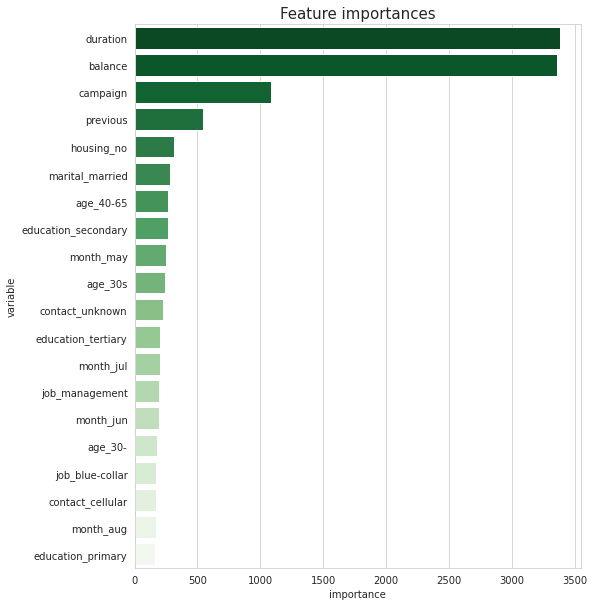

In [88]:
lgbm_tuned = LGBMClassifier(n_estimators=200,max_depth=10, num_leaves=20, objective='binary',boost_from_average=False)
get_result(lgbm_tuned,X,y)

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      7985
           1       0.56      0.59      0.58      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.77      0.76      9043
weighted avg       0.90      0.90      0.90      9043

[[7501  484]
 [ 432  626]]


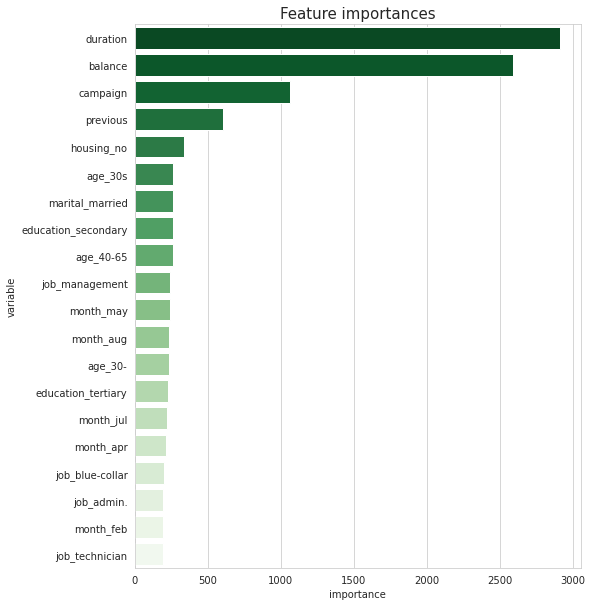

In [89]:
lgbm_tuned_over = LGBMClassifier(n_estimators=300,max_depth=20, num_leaves=50, objective='binary',boost_from_average=False)
get_result_over(lgbm_tuned_over,X,y)

### (3) Logistic Regression

In [90]:
lr = LogisticRegression(random_state=0)
lr_params = {'penalty':['l2','l1'],'C':[0.01,0.1,1,5,10]}

In [91]:
outer_accuracy_lr, final_accuracy_lr, train_accuracy_lr, precision_lr, recall_lr = nested_cross_val(lr,X,y,lr_params,outer_cv,inner_cv)

###### 1th fold result ######
Best parameter:  {'C': 5, 'penalty': 'l2'}
Accuracy score:  0.9
###### 2th fold result ######
Best parameter:  {'C': 10, 'penalty': 'l2'}
Accuracy score:  0.9042
###### 3th fold result ######
Best parameter:  {'C': 5, 'penalty': 'l2'}
Accuracy score:  0.9049
###### 4th fold result ######
Best parameter:  {'C': 5, 'penalty': 'l2'}
Accuracy score:  0.899
###### 5th fold result ######
Best parameter:  {'C': 10, 'penalty': 'l2'}
Accuracy score:  0.8994


In [92]:
outer_accuracy_lr2, final_accuracy_lr2, train_accuracy_lr2, precision_lr2, recall_lr2 = nested_cross_val_over(lr,X,y,lr_params,outer_cv,inner_cv)

###### 1th fold result ######
Best parameter:  {'C': 10, 'penalty': 'l2'}
Accuracy score:  0.8467
###### 2th fold result ######
Best parameter:  {'C': 5, 'penalty': 'l2'}
Accuracy score:  0.8516
###### 3th fold result ######
Best parameter:  {'C': 5, 'penalty': 'l2'}
Accuracy score:  0.8524
###### 4th fold result ######
Best parameter:  {'C': 10, 'penalty': 'l2'}
Accuracy score:  0.8508
###### 5th fold result ######
Best parameter:  {'C': 10, 'penalty': 'l2'}
Accuracy score:  0.8443


In [93]:
lr_tuned = LogisticRegression(penalty='l2',C=5,random_state=0)

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7985
           1       0.64      0.33      0.44      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.65      0.69      9043
weighted avg       0.88      0.90      0.89      9043

[[7783  202]
 [ 704  354]]


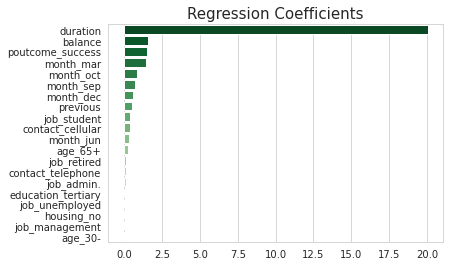

In [94]:
get_result(lr_tuned,X,y)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91      7985
           1       0.42      0.82      0.56      1058

    accuracy                           0.85      9043
   macro avg       0.70      0.84      0.73      9043
weighted avg       0.91      0.85      0.87      9043

[[6792 1193]
 [ 189  869]]


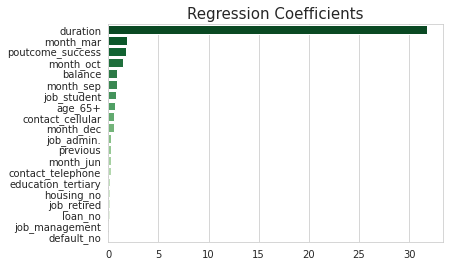

In [95]:
get_result_over(lr_tuned,X,y)

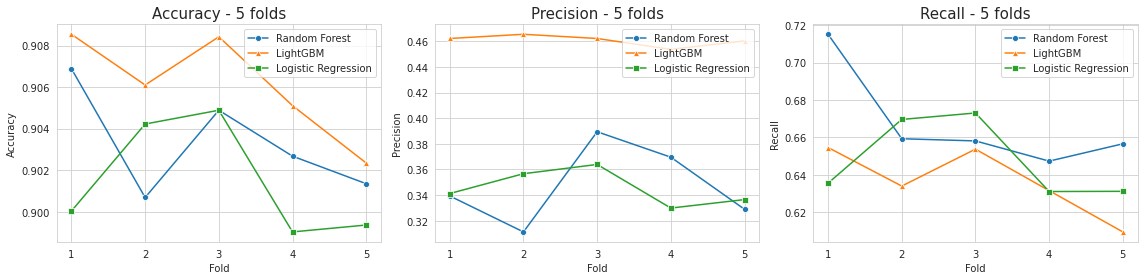

In [96]:
# model performance comparison plot
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.lineplot(x=range(1,6), y=outer_accuracy_rf,marker='o', label='Random Forest')
sns.lineplot(x=range(1,6), y=outer_accuracy_lgbm,marker='^',label='LightGBM')
sns.lineplot(x=range(1,6), y=outer_accuracy_lr,marker='s', label='Logistic Regression')
plt.title('Accuracy - 5 folds',fontsize=15); plt.xticks([1,2,3,4,5]); plt.xlabel('Fold'); plt.ylabel('Accuracy');plt.legend(loc='upper right')

plt.subplot(1,3,2)
sns.lineplot(x=range(1,6), y=precision_rf,marker='o', label='Random Forest')
sns.lineplot(x=range(1,6), y=precision_lgbm,marker='^',label='LightGBM')
sns.lineplot(x=range(1,6), y=precision_lr,marker='s', label='Logistic Regression')
plt.title('Precision - 5 folds',fontsize=15); plt.xticks([1,2,3,4,5]); plt.xlabel('Fold'); plt.ylabel('Precision');plt.legend(loc='upper right')

plt.subplot(1,3,3)
sns.lineplot(x=range(1,6), y=recall_rf,marker='o', label='Random Forest')
sns.lineplot(x=range(1,6), y=recall_lgbm,marker='^',label='LightGBM')
sns.lineplot(x=range(1,6), y=recall_lr,marker='s', label='Logistic Regression')
plt.title('Recall - 5 folds',fontsize=15); plt.xticks([1,2,3,4,5]); plt.xlabel('Fold'); plt.ylabel('Recall');plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

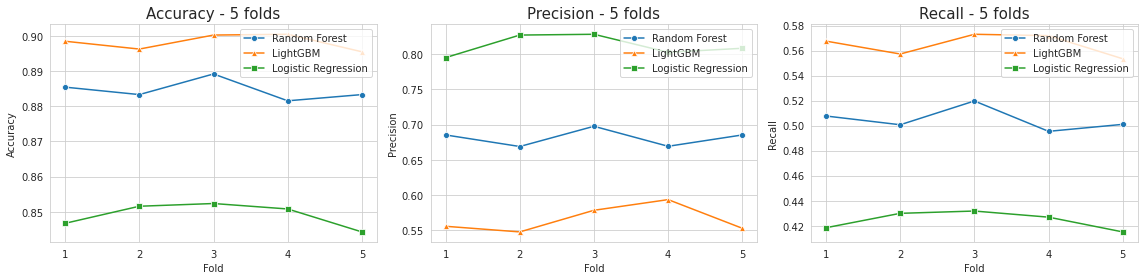

In [97]:
# oversampled models comparison plot
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
sns.lineplot(x=range(1,6), y=outer_accuracy_rf2,marker='o', label='Random Forest')
sns.lineplot(x=range(1,6), y=outer_accuracy_lgbm2,marker='^',label='LightGBM')
sns.lineplot(x=range(1,6), y=outer_accuracy_lr2,marker='s', label='Logistic Regression')
plt.title('Accuracy - 5 folds',fontsize=15); plt.xticks([1,2,3,4,5]); plt.xlabel('Fold'); plt.ylabel('Accuracy');plt.legend(loc='upper right')

plt.subplot(1,3,2)
sns.lineplot(x=range(1,6), y=precision_rf2,marker='o', label='Random Forest')
sns.lineplot(x=range(1,6), y=precision_lgbm2,marker='^',label='LightGBM')
sns.lineplot(x=range(1,6), y=precision_lr2,marker='s', label='Logistic Regression')
plt.title('Precision - 5 folds',fontsize=15); plt.xticks([1,2,3,4,5]); plt.xlabel('Fold'); plt.ylabel('Precision');plt.legend(loc='upper right')

plt.subplot(1,3,3)
sns.lineplot(x=range(1,6), y=recall_rf2,marker='o', label='Random Forest')
sns.lineplot(x=range(1,6), y=recall_lgbm2,marker='^',label='LightGBM')
sns.lineplot(x=range(1,6), y=recall_lr2,marker='s', label='Logistic Regression')
plt.title('Recall - 5 folds',fontsize=15); plt.xticks([1,2,3,4,5]); plt.xlabel('Fold'); plt.ylabel('Recall');plt.legend(loc='upper right')

plt.tight_layout()
plt.show()